In [3]:
import pickle 
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
import momepy as mp
import networkx as nx
import numpy as np

from collections import defaultdict
from typing import Iterable, List, Optional, Sequence, Tuple, Any, Dict
from shapely.geometry import LineString

In [4]:
with open("/Users/sashamorozov/Documents/Code/TNDP_buses/TNDP_buses/data/graph_preprocessed.pickle", "rb") as f:
    graph = pickle.load(f)

In [5]:
G = nx.convert_node_labels_to_integers(graph)

In [6]:
G.graph['crs']

<Projected CRS: EPSG:32636>
Name: WGS 84 / UTM zone 36N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 30°E and 36°E, northern hemisphere between equator and 84°N, onshore and offshore. Belarus. Cyprus. Egypt. Ethiopia. Finland. Israel. Jordan. Kenya. Lebanon. Moldova. Norway. Russian Federation. Saudi Arabia. Sudan. Syria. Türkiye (Turkey). Uganda. Ukraine.
- bounds: (30.0, 0.0, 36.0, 84.0)
Coordinate Operation:
- name: UTM zone 36N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [21]:
G.edges(data=True)

EdgeDataView([(0, 1, {'weight': 447.4853600387423, 'time_min': 1.3424560801162269, 'geometry': <LINESTRING (343148.795 6647728.635, 343183.681 6647604.79, 343262.987 66474...>, 'original_path': [325, 154, 156, 155, 64, 326]}), (0, 4, {'weight': 437.28467676181, 'time_min': 1.3118540302854298, 'geometry': <LINESTRING (343360.718 6647411.983, 343306.246 6647384.168, 343398.236 6647...>, 'original_path': [325, 154, 153, 329]}), (1, 4, {'weight': 762.4457956582761, 'time_min': 2.2873373869748286, 'geometry': <LINESTRING (343148.795 6647728.635, 343183.681 6647604.79, 343262.987 66474...>, 'original_path': [326, 64, 155, 156, 154, 153, 329]}), (1, 9, {'weight': 520.3036339015117, 'time_min': 1.5609109017045353, 'geometry': <LINESTRING (343153.224 6648237.767, 343129.528 6648166.682, 343136.807 6648...>, 'original_path': [326, 323, 324, 335]}), (2, 29, {'weight': 291.5955477686287, 'time_min': 0.8747866433058862, 'geometry': <LINESTRING (345363.883 6648077.661, 345420.523 6647791.62)>, 'orig

In [7]:
with open("/Users/sashamorozov/Downloads/neural_bco_exp_vo_pp_0.33_op_0.33_cp_0.33_generated_routes.pkl", "rb") as f:
    routes = pickle.load(f)[0].tolist()

In [8]:
def build_route_multigraph(
    G: nx.Graph,
    routes: List[List[int]],
    route_ids: Optional[Sequence[Any]] = None,   # если хочешь свои имена для маршрутов
    pad_value: int = -1,                         # игнорируемые элементы в маршруте
    pick_attr: str = "time_min",                 # по какому атрибуту выбирать одно из параллельных рёбер
    copy_attrs: Tuple[str, ...] = ("weight", "time_min", "geometry", "original_path"),
    keep_direction: Optional[bool] = None,       # None -> наследуем от G.is_directed()
    fallback_to_reverse: bool = True,            # если (u,v) нет, но есть (v,u), можно взять его
    build_geom_from_nodes: bool = True,          # если на ребре нет geometry, собрать из координат узлов
    node_x_attr: str = "x",
    node_y_attr: str = "y",
) -> Tuple[nx.MultiGraph, Dict[str, Any]]:
    """
    Создаёт новый nx.MultiGraph, где каждое ребро — отдельный сегмент конкретного маршрута.
    Возвращает (H, stats).
    """

    if keep_direction is None:
        keep_direction = G.is_directed()

    H = nx.MultiDiGraph() if keep_direction else nx.MultiGraph()

    # перенесём узлы с атрибутами
    H.add_nodes_from(G.nodes(data=True))

    def clean_seq(seq: Iterable[int]) -> List[int]:
        # выкинуть pad_value и подряд идущие дубли, оставить только узлы, которые есть в графе
        s = [n for n in seq if n != pad_value]
        if not s:
            return []
        out = [s[0]]
        for x in s[1:]:
            if x != out[-1]:
                out.append(x)
        # фильтр по наличию в графе
        return [n for n in out if G.has_node(n)]

    # удобный выбор «лучшего» ребра среди параллельных
    def choose_best_edge(u, v):
        """
        Возвращает tuple: (uu, vv, key, data) выбранного ребра,
        где (uu,vv) могут быть (v,u), если fallback_to_reverse=True.
        Или None, если ничего не нашли.
        """
        # helper: взять список (key, data) для пары
        def multi_items(a, b):
            return list(G[a][b].items()) if G.is_multigraph() else [(None, G[a][b])]

        # кандидат(ы) по прямому направлению
        cand = []
        if G.has_edge(u, v):
            cand.extend([(u, v, k, d) for k, d in multi_items(u, v)])
        # при необходимости — по обратному направлению
        if (not keep_direction) or (fallback_to_reverse and G.has_edge(v, u)):
            cand.extend([(v, u, k, d) for k, d in multi_items(v, u)])

        if not cand:
            return None

        def pick_val(tup):
            d = tup[3]
            val = d.get(pick_attr, None)
            return float("inf") if val is None else val

        # выбрать минимум по pick_attr
        return min(cand, key=pick_val)

    stats = {
        "missing_nodes": set(),
        "missing_segments": [],   # (route_id, u, v)
        "used_reverse_edge": 0,
        "built_geom_fallback": 0,
        "edges_created": 0,
        "routes_processed": 0,
    }

    for ridx, seq in enumerate(routes):
        route_id = route_ids[ridx] if (route_ids is not None) else (ridx + 1)
        path = clean_seq(seq)
        if len(path) < 2:
            continue

        seg_ix = 0
        for u, v in zip(path[:-1], path[1:]):
            if u == v:
                continue

            chosen = choose_best_edge(u, v)
            if chosen is None:
                stats["missing_segments"].append((route_id, u, v))
                continue

            uu, vv, key, data = chosen
            if (uu, vv) != (u, v):
                stats["used_reverse_edge"] += 1

            # собираем атрибуты нового ребра
            attrs = {"route_id": route_id, "segment_ix": seg_ix, "uv_from": (u, v)}
            for a in copy_attrs:
                if a in data:
                    attrs[a] = data[a]

            # если геометрии нет — пробуем собрать из координат узлов
            if ("geometry" not in attrs or attrs["geometry"] is None) and build_geom_from_nodes:
                xu, yu = H.nodes[uu].get(node_x_attr), H.nodes[uu].get(node_y_attr)
                xv, yv = H.nodes[vv].get(node_x_attr), H.nodes[vv].get(node_y_attr)
                if None not in (xu, yu, xv, yv):
                    attrs["geometry"] = LineString([(xu, yu), (xv, yv)])
                    stats["built_geom_fallback"] += 1

            # ключ делаем уникальным по маршруту и порядку сегмента
            H.add_edge(uu, vv, key=(route_id, seg_ix), **attrs)
            stats["edges_created"] += 1
            seg_ix += 1

        stats["routes_processed"] += 1

    # привести множества к спискам для печати
    stats["missing_nodes"] = sorted(stats["missing_nodes"])
    return H, stats

In [9]:
G_routes, stats = build_route_multigraph(
    G,
    routes,
    route_ids=None,         # или передай список названий/ID маршрутов длины len(routes)
    pad_value=-1,
    pick_attr="time_min",   # выбирать среди параллельных рёбер минимальное время (можно "weight")
    copy_attrs=("weight", "time_min", "geometry", "original_path"),
    keep_direction=False,   # хотим неориентированный MultiGraph; True -> MultiDiGraph
)

In [10]:
stats

{'missing_nodes': [],
 'missing_segments': [],
 'used_reverse_edge': 0,
 'built_geom_fallback': 0,
 'edges_created': 147,
 'routes_processed': 10}

In [11]:
G_routes.graph["crs"] = 32636

In [12]:
G_routes.edges(data=True)

MultiEdgeDataView([(0, 1, {'route_id': 7, 'segment_ix': 10, 'uv_from': (1, 0), 'weight': 447.4853600387423, 'time_min': 1.3424560801162269, 'geometry': <LINESTRING (343148.795 6647728.635, 343183.681 6647604.79, 343262.987 66474...>, 'original_path': [325, 154, 156, 155, 64, 326]}), (1, 9, {'route_id': 1, 'segment_ix': 21, 'uv_from': (9, 1), 'weight': 520.3036339015117, 'time_min': 1.5609109017045353, 'geometry': <LINESTRING (343153.224 6648237.767, 343129.528 6648166.682, 343136.807 6648...>, 'original_path': [326, 323, 324, 335]}), (1, 9, {'route_id': 7, 'segment_ix': 9, 'uv_from': (9, 1), 'weight': 520.3036339015117, 'time_min': 1.5609109017045353, 'geometry': <LINESTRING (343153.224 6648237.767, 343129.528 6648166.682, 343136.807 6648...>, 'original_path': [326, 323, 324, 335]}), (1, 4, {'route_id': 1, 'segment_ix': 22, 'uv_from': (1, 4), 'weight': 762.4457956582761, 'time_min': 2.2873373869748286, 'geometry': <LINESTRING (343148.795 6647728.635, 343183.681 6647604.79, 343262.987 6

In [14]:
with open('G_routes.pkl', 'wb') as file:
        pickle.dump(G_routes, file)

In [17]:
n,e = mp.nx_to_gdf(G_routes)

/var/folders/zx/byb3bcds50s1lwbdr2mwq18r0000gn/T/ipykernel_4167/1110436813.py:1: UserWarning: Approach is not set. Defaulting to 'primal'.
  n,e = mp.nx_to_gdf(G_routes)


In [ ]:
e[e['route_id'] == 2].explore()

#### Компоненты и графовая связность 

In [15]:
nx.number_connected_components(G_routes)

1

In [13]:
def connected_pair_fraction(G: nx.Graph) -> float:
    """
    Доля (0..1) неупорядоченных пар узлов {i,j}, между которыми существует путь.
    Работает для Graph/MultiGraph (ненаправленных). Вес/петли игнорируются.
    """
    if G.is_directed():
        raise ValueError("Ожидается ненаправленный граф (Graph/MultiGraph).")

    N = G.number_of_nodes()
    if N < 2:
        return 1.0  # по договорённости: тривиальный случай

    # размеры компонент
    sizes = (len(c) for c in nx.connected_components(G))
    numerator = sum(s * (s - 1) for s in sizes)   # сумма по компонентам
    denominator = N * (N - 1)
    return numerator / denominator

In [14]:
frac = connected_pair_fraction(G_routes)
print(f"{frac:.3f}")

1.000


#### Распределения степенец вершин

In [15]:
import networkx as nx, numpy as np, math, collections

def poisson_goodness_of_fit_for_degrees(G):
    deg = [d for _, d in G.degree()]        # степени
    lam = float(np.mean(deg))               # оценка λ
    cnt = collections.Counter(deg)          # эмпирические частоты
    n = len(deg)
    kmax = max(cnt) if cnt else 0

    # теоретические вероятности и ожидаемые частоты
    pmf = [math.exp(-lam) * lam**k / math.factorial(k) for k in range(kmax+1)]
    expected = [n * p for p in pmf]
    observed = [cnt.get(k, 0) for k in range(kmax+1)]

    return {
        "lambda_hat": lam,
        "observed": observed,
        "expected": expected,
        "support_k": list(range(kmax+1)),
    }

In [16]:
res = poisson_goodness_of_fit_for_degrees(G_routes)
print("λ̂ =", res["lambda_hat"])
for k, obs, exp in zip(res["support_k"], res["observed"], res["expected"]):
    print(f"k={k:2d}: obs={obs:5.0f}  exp={exp:7.2f}")

λ̂ = 2.7222222222222223
k= 0: obs=    0  exp=   7.10
k= 1: obs=   12  exp=  19.32
k= 2: obs=   58  exp=  26.30
k= 3: obs=    3  exp=  23.87
k= 4: obs=   27  exp=  16.24
k= 5: obs=    1  exp=   8.84
k= 6: obs=    6  exp=   4.01
k= 7: obs=    0  exp=   1.56
k= 8: obs=    1  exp=   0.53


In [15]:
import math
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

def poisson_degree_plot(
    G: nx.Graph,
    kind: str = "undirected",   # "undirected" | "in" | "out"
    normalize: bool = True,      # True -> вероятности; False -> абсолютные частоты
    max_k: int | None = None,    # ограничение по оси X; по умолчанию берётся max из данных
    title: str | None = None,
):
    # 1) степени
    if kind == "undirected":
        deg = [d for _, d in G.degree()]
    elif kind == "in":
        deg = [d for _, d in G.in_degree()]
    elif kind == "out":
        deg = [d for _, d in G.out_degree()]
    else:
        raise ValueError("kind must be 'undirected', 'in', or 'out'")

    n = len(deg)
    if n == 0:
        raise ValueError("Граф пустой.")

    lam = float(np.mean(deg))
    if max_k is None:
        max_k = int(max(deg)) if deg else 0
        # мягкая «шапка», если хвост длинный:
        if lam > 0:
            max_k = max_k if max_k <= lam + 4*np.sqrt(lam) else int(lam + 4*np.sqrt(lam))

    # 2) эмпирика (наблюдаемое распределение степеней)
    counts = np.bincount(deg, minlength=max_k + 1)
    if normalize:
        tot = counts.sum()
        observed = counts / tot if tot > 0 else counts
        y_label = "Probability"
    else:
        observed = counts
        y_label = "Count"

    ks = np.arange(0, max_k + 1)

    # 3) теоретическое Пуассоновское (с λ̂ = mean degree)
    pmf = np.array([math.exp(-lam) * lam**k / math.factorial(k) for k in ks])
    expected = pmf if normalize else n * pmf

    # 4) график (1 полотно, без явной палитры)
    fig, ax = plt.subplots()
    ax.bar(ks, observed, label="Observed")
    ax.plot(ks, expected, marker="o", label=f"Poisson(λ̂={lam:.2f})")
    ax.set_xlabel("degree k")
    ax.set_ylabel(y_label)
    ax.set_title(title or f"Degree distribution vs Poisson (kind={kind})")
    ax.legend()
    plt.show()

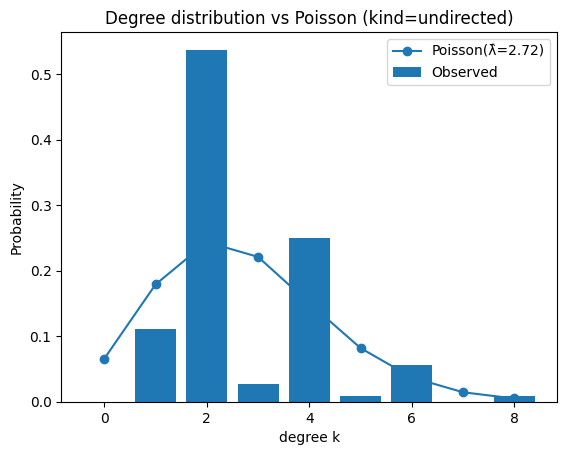

In [16]:
poisson_degree_plot(G_routes, kind="undirected", normalize=True)


In [ ]:
def get_degrees(G: nx.Graph, kind: str = "undirected", unique_neighbors: bool = False):
    """
    Возвращает список степеней вершин.
    kind:
      - "undirected"  — степень для ненаправленного графа или сумма in+out для DiGraph
      - "in"          — входящая степень (только для DiGraph/MultiDiGraph)
      - "out"         — исходящая степень (только для DiGraph/MultiDiGraph)
    unique_neighbors:
      - False (по умолчанию): в MultiGraph параллельные рёбра учитываются (классическая degree)
      - True: схлопывать параллельные рёбра (степень = число уникальных соседей)
    """
    H = G
    if unique_neighbors:
        # схлопнем параллельные рёбра; для DiGraph получим простой DiGraph
        H = nx.DiGraph(G) if G.is_directed() else nx.Graph(G)

    if kind == "undirected":
        if H.is_directed():
            deg = [H.in_degree(n) + H.out_degree(n) for n in H.nodes()]
        else:
            deg = [d for _, d in H.degree()]
    elif kind == "in":
        if not H.is_directed():
            raise ValueError("kind='in' применим только к направленным графам")
        deg = [d for _, d in H.in_degree()]
    elif kind == "out":
        if not H.is_directed():
            raise ValueError("kind='out' применим только к направленным графам")
        deg = [d for _, d in H.out_degree()]
    else:
        raise ValueError("kind must be 'undirected' | 'in' | 'out'")
    return deg

def plot_degree_distribution(
    G: nx.Graph,
    kind: str = "undirected",
    unique_neighbors: bool = False,
    normalize: bool = True,
    max_k: int | None = None,
    logy: bool = False,
    title: str | None = None,
):
    deg = get_degrees(G, kind=kind, unique_neighbors=unique_neighbors)
    if len(deg) == 0:
        raise ValueError("Граф пустой")

    k_max_data = max(deg)
    if max_k is None:
        max_k = k_max_data
    ks = np.arange(0, max_k + 1)

    counts = np.bincount(deg, minlength=max_k + 1)
    if normalize:
        total = counts.sum()
        ys = counts / total if total > 0 else counts
        ylabel = "Probability"
    else:
        ys = counts
        ylabel = "Count"

    # рисуем один график (без указания цветов/стилей)
    fig, ax = plt.subplots()
    ax.bar(ks, ys, label="Degree distribution")
    ax.set_xlabel("degree k")
    ax.set_ylabel(ylabel)
    ax.set_title(title or f"Degree distribution (kind={kind}, unique_neighbors={unique_neighbors})")
    if logy:
        ax.set_yscale("log")
    ax.legend()
    plt.show()

    # небольшая сводка
    mean_k = float(np.mean(deg))
    print(f"N={len(deg)} | mean degree = {mean_k:.3f} | max degree = {k_max_data}")

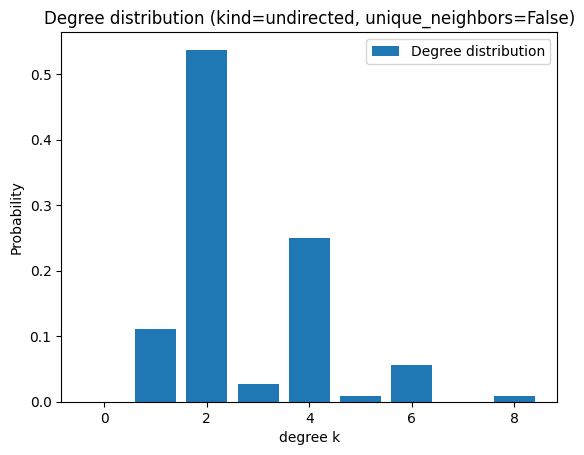

N=108 | mean degree = 2.722 | max degree = 8


In [22]:
plot_degree_distribution(G_routes, kind="undirected", unique_neighbors=False, normalize=True)

In [9]:
deg_edges = [d for _, d in G_routes.degree()]

In [17]:
def plot_deg_edges_distribution(
    G: nx.Graph,
    normalize: bool = True,   # True -> вероятности; False -> абсолютные частоты
    max_k: int | None = None, # ограничение по оси X
    logy: bool = False,       # лог-масштаб по Y
    title: str | None = None,
):
    # 1) степени по числу рёбер (учитываются параллельные рёбра в MultiGraph)
    deg = [d for _, d in G.degree()] if not G.is_directed() else [G.in_degree(n)+G.out_degree(n) for n in G.nodes()]
    if not deg:
        raise ValueError("Граф пустой.")

    # 2) гистограмма по k = 0..max_k
    k_max_data = max(deg)
    if max_k is None:
        max_k = k_max_data
    counts = np.bincount(deg, minlength=max_k + 1)
    ks = np.arange(0, max_k + 1)

    # 3) нормировать (по желанию)
    if normalize:
        total = counts.sum()
        ys = counts / total if total > 0 else counts
        ylabel = "Probability"
    else:
        ys = counts
        ylabel = "Count"

    # 4) один простой график
    fig, ax = plt.subplots()
    ax.bar(ks, ys, label="deg_edges")
    ax.set_xlabel("degree k (by edges)")
    ax.set_ylabel(ylabel)
    ax.set_title(title or "Degree distribution (edge-count degree)")
    if logy:
        ax.set_yscale("log")
    ax.legend()
    plt.show()

    print(f"N={len(deg)} | average degree={np.average(deg):.3f} | max degree={k_max_data}")


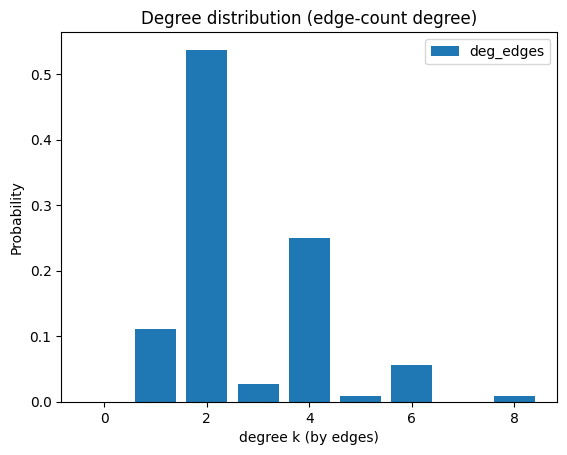

N=108 | average degree=2.722 | max degree=8


In [18]:
plot_deg_edges_distribution(G_routes, normalize=True, logy=False)

In [13]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

def get_degrees(G: nx.Graph, kind: str = "undirected", unique_neighbors: bool = False):
    H = nx.DiGraph(G) if (unique_neighbors and G.is_directed()) else (nx.Graph(G) if unique_neighbors else G)
    if kind == "undirected":
        return [H.in_degree(n)+H.out_degree(n) for n in H.nodes()] if H.is_directed() else [d for _, d in H.degree()]
    elif kind == "in":
        if not H.is_directed(): raise ValueError("kind='in' только для направленных графов")
        return [d for _, d in H.in_degree()]
    elif kind == "out":
        if not H.is_directed(): raise ValueError("kind='out' только для направленных графов")
        return [d for _, d in H.out_degree()]
    else:
        raise ValueError("kind must be 'undirected' | 'in' | 'out'")

def plot_degree_distribution(
    G: nx.Graph,
    kind: str = "undirected",
    unique_neighbors: bool = False,
    y_mode: str = "fraction",   # "fraction" | "percent" | "count"
    max_k: int | None = None,
    logy: bool = False,
    title: str | None = None,
):
    deg = get_degrees(G, kind=kind, unique_neighbors=unique_neighbors)
    if not deg: raise ValueError("Граф пустой")

    k_max = max(deg) if max_k is None else max_k
    counts = np.bincount(deg, minlength=k_max + 1)
    ks = np.arange(0, k_max + 1)

    total = counts.sum()
    if y_mode == "count":
        ys = counts;       ylabel = "Count of nodes"
    elif y_mode == "percent":
        ys = 100 * counts / total if total else counts; ylabel = "Percent of nodes (%)"
    else:  # "fraction" (то же, что «probability» в прошлой версии)
        ys = counts / total if total else counts;       ylabel = "Fraction of nodes"

    fig, ax = plt.subplots()
    ax.bar(ks, ys, label="Degree distribution")
    ax.set_xlabel("degree k")
    ax.set_ylabel(ylabel)
    ax.set_title(title or f"Degree distribution (kind={kind}, unique_neighbors={unique_neighbors})")
    if logy: ax.set_yscale("log")
    ax.legend(); plt.show()

    print(f"N={len(deg)} | mean degree={np.mean(deg):.3f} | max degree={max(deg)}")

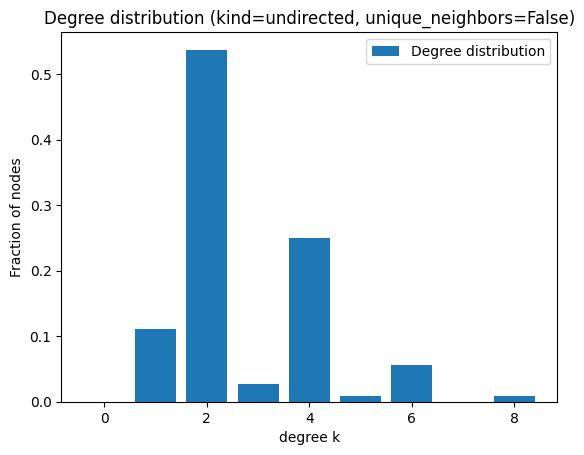

N=108 | mean degree=2.722 | max degree=8


In [14]:
plot_degree_distribution(G_routes, y_mode="fraction")

In [ ]:
plot_degree_panel(G, kind="undirected", title="Undirected degree (regular)")

In [ ]:
e.explore()

In [ ]:
e[e['route_id'] == 2].explore()

#### Nodes coords for gdf

In [3]:
coord_file = "/Users/sashamorozov/Documents/Code/GNN/TNDP_learning/datasets/vo_dataset/VOCoords.txt"

# 1. Загрузка координат
with open(coord_file, "r") as f:
    lines = f.readlines()[1:]  # Пропускаем первую строку (кол-во точек)
coords = [list(map(float, line.strip().split())) for line in lines]
df = pd.DataFrame(coords, columns=["x", "y"])

# 2. Создание GeoDataFrame в системе UTM (метры)
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["x"], df["y"]),
    crs="EPSG:32636"  # UTM зона 35N, Санкт-Петербург
)

# # 3. Преобразование в WGS84 (широта/долгота)
gdf = gdf.to_crs(32636)
gdf['id'] = gdf.index

In [4]:
gdf

,x,y,geometry,id
0,343360.72,6647411.98,POINT (343360.72 6647411.98),0
1,343148.80,6647728.63,POINT (343148.8 6647728.63),1
2,345363.88,6648077.66,POINT (345363.88 6648077.66),2
3,345811.40,6649628.59,POINT (345811.4 6649628.59),3
4,343532.03,6647105.09,POINT (343532.03 6647105.09),4
...,...,...,...,...
103,347641.91,6648586.00,POINT (347641.91 6648586),103
104,347525.03,6648697.80,POINT (347525.03 6648697.8),104
105,348298.23,6648636.49,POINT (348298.23 6648636.49),105
106,347963.67,6648755.79,POINT (347963.67 6648755.79),106


In [5]:
id_to_xy = gdf.set_index("id")["geometry"].apply(lambda p: (p.x, p.y)).to_dict()

def dedup_consecutive(seq):
    out = []
    for v in seq:
        if not out or v != out[-1]:
            out.append(v)
    return out

records = []
missing_global = set()

In [6]:
for rid, id_seq in enumerate(routes, start=1):
    # 1) выбросить паддинг -1
    seq = [i for i in id_seq if i != -1]
    # 2) убрать подряд идущие дубли (1,1,2,2,3 -> 1,2,3)
    seq = dedup_consecutive(seq)
    # 3) собрать координаты; запомнить отсутствующие id
    coords, missing = [], []
    for i in seq:
        xy = id_to_xy.get(i)
        if xy is None:
            missing.append(i); missing_global.add(i)
        else:
            coords.append(xy)
    # 4) строим линию, если есть хотя бы 2 точки
    if len(coords) >= 2:
        geom = LineString(coords)
        records.append({
            "route_id": rid,
            "n_ids": len(seq),
            "n_missing": len(missing),
            "geometry": geom
        })
    # если <2 точек — пропускаем (нет линии)

routes_gdf = gpd.GeoDataFrame(records, geometry="geometry", crs=gdf.crs)
routes_gdf["length_m"] = routes_gdf.geometry.length
routes_gdf["length_km"] = (routes_gdf["length_m"] / 1000).round(3)

In [7]:
routes_gdf

,route_id,n_ids,n_missing,geometry,length_m,length_km
0,1,24,0,"LINESTRING (348793.76 6647605.35, 348761.59 66...",8787.354900,8.787
1,2,19,0,"LINESTRING (346587.48 6646315.91, 346690.64 66...",4498.433000,4.498
2,3,22,0,"LINESTRING (345416.54 6649745.96, 345811.4 664...",7374.037956,7.374
3,4,10,0,"LINESTRING (344031.23 6648225.27, 344152.96 66...",3789.297844,3.789
4,5,24,0,"LINESTRING (344311.25 6647732.43, 344559.07 66...",8397.497461,8.397
5,6,10,0,"LINESTRING (347641.91 6648586, 347279.97 66483...",3537.412850,3.537
6,7,12,0,"LINESTRING (345416.54 6649745.96, 345061.14 66...",4295.819569,4.296
7,8,10,0,"LINESTRING (345771.29 6646377.23, 345834.29 66...",2747.256434,2.747
8,9,22,0,"LINESTRING (347469.17 6647072.21, 347440.42 66...",6564.722427,6.565
9,10,4,0,"LINESTRING (344975.32 6649035.73, 345401.38 66...",1116.829193,1.117


In [17]:
routes_gdf[routes_gdf['route_id'] == 10].explore()

In [1]:
import math

import geopandas as gpd
import networkx as nx
import momepy as mp
import numpy as np

from shapely.geometry import LineString, MultiLineString
from shapely.ops import linemerge


/Users/sashamorozov/Documents/Code/GNN/metrics/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
routes_gdf = gpd.read_file("./routes_gdf.geojson")

In [3]:
local_crs = routes_gdf.estimate_utm_crs()
routes_gdf.to_crs(local_crs, inplace = True)

In [ ]:
routes_gdf.explore('route_id')

#### Длина маршрутов

In [4]:
routes_gdf["length"] = routes_gdf.geometry.length
total_km = float(routes_gdf["length"].sum() / 1000)
print(f"Суммарная длина всех маршрутов: {total_km:.3f} км")

Суммарная длина всех маршрутов: 76.997 км


In [23]:
routes_gdf.explore('route_id')

#### Прямота directness

In [5]:
def end_to_end_euclid_m(ls):
    if ls is None or ls.is_empty:
        return np.nan
    coords = getattr(ls, "coords", None)
    if coords is None or len(coords) < 2:
        return np.nan
    x1, y1 = coords[0]
    x2, y2 = coords[-1]
    return math.hypot(x2 - x1, y2 - y1)

In [6]:
routes_gdf["euclid_m"] = routes_gdf.geometry.apply(end_to_end_euclid_m)
routes_gdf["euclid_km"] = (routes_gdf.geometry.apply(end_to_end_euclid_m) / 1000).round(3)
routes_gdf["straightness"] = (routes_gdf["euclid_m"] / routes_gdf["length"]).where(routes_gdf["length"] > 0)
routes_gdf["straightness"] = routes_gdf["straightness"].clip(lower=0, upper=1)
routes_gdf["length_km"] = (routes_gdf["length"] / 1000).round(3)


In [7]:
routes_gdf

,route_id,geometry,length,euclid_m,euclid_km,straightness,length_km
0,0,"LINESTRING (343532.03 6647105.09, 343148.8 664...",9304.279863,5905.814798,5.906,0.634742,9.304
1,1,"LINESTRING (344826.99 6650220.28, 345277.24 66...",6955.407095,4488.197968,4.488,0.645282,6.955
2,2,"LINESTRING (343360.72 6647411.98, 343148.8 664...",7343.269083,4662.592088,4.663,0.634948,7.343
3,3,"LINESTRING (346216.32 6649191.17, 346059.08 66...",7246.196544,1266.153573,1.266,0.174734,7.246
4,4,"LINESTRING (345061.14 6649796.95, 344710.96 66...",6977.398654,3613.354512,3.613,0.517866,6.977
5,5,"LINESTRING (346885.43 6648497.02, 347115.33 66...",3353.160838,1857.477930,1.857,0.553948,3.353
6,6,"LINESTRING (349381.15 6647921.45, 349071.54 66...",8953.408264,6041.948118,6.042,0.674821,8.953
7,7,"LINESTRING (343298.33 6648635.86, 343482.18 66...",8255.048611,5591.216482,5.591,0.677309,8.255
8,8,"LINESTRING (349381.15 6647921.45, 349071.54 66...",9304.279863,5905.814798,5.906,0.634742,9.304
9,9,"LINESTRING (343532.03 6647105.09, 343148.8 664...",9304.279863,5905.814798,5.906,0.634742,9.304


#### Плотность остановок на линии

In [8]:
def _unique_points_ls(ls, tol=None):
    """Список уникальных точек LineString. tol (м) можно задать для грубого снаппинга."""
    pts, seen = [], set()
    for x, y in ls.coords:
        if tol is not None:
            key = (round(x / tol) * tol, round(y / tol) * tol)
        else:
            key = (x, y)
        if key not in seen:
            seen.add(key)
            pts.append(key)
    return pts

def count_stops(geom, tol=None):
    """Число уникальных «остановок» = уникальных вершин линии (start/end каждого сегмента)."""
    if geom is None or geom.is_empty:
        return 0
    if isinstance(geom, LineString):
        return len(_unique_points_ls(geom, tol))
    if isinstance(geom, MultiLineString):
        merged = linemerge(geom)
        if isinstance(merged, LineString):
            return len(_unique_points_ls(merged, tol))
        # если осталось несколько линий — объединяем множества точек
        seen = set()
        for part in merged.geoms:
            for pt in _unique_points_ls(part, tol):
                seen.add(pt)
        return len(seen)
    return 0

In [9]:
tol = None
routes_gdf["stops_n"] = routes_gdf.geometry.apply(lambda geom: count_stops(geom, tol))

In [10]:
routes_gdf["stops_per_km"] = (routes_gdf["stops_n"] / routes_gdf["length_km"]).replace([np.inf, -np.inf], np.nan)

# средний интервал между остановками (км между соседними остановками)
# используем (stops_n - 1), чтобы считать интервалы; защита на 0
routes_gdf["avg_spacing_km"] = (routes_gdf["length_km"] / np.maximum(routes_gdf["stops_n"] - 1, 1)).replace([np.inf, -np.inf], np.nan)

In [25]:
routes_gdf

,route_id,geometry,length,euclid_m,euclid_km,straightness,length_km,stops_n,stops_per_km,avg_spacing_km
0,0,"LINESTRING (343532.03 6647105.09, 343148.8 664...",9304.279863,5905.814798,5.906,0.634742,9.304,25,2.687016,0.387667
1,1,"LINESTRING (344826.99 6650220.28, 345277.24 66...",6955.407095,4488.197968,4.488,0.645282,6.955,24,3.450755,0.302391
2,2,"LINESTRING (343360.72 6647411.98, 343148.8 664...",7343.269083,4662.592088,4.663,0.634948,7.343,18,2.451314,0.431941
3,3,"LINESTRING (346216.32 6649191.17, 346059.08 66...",7246.196544,1266.153573,1.266,0.174734,7.246,24,3.312172,0.315043
4,4,"LINESTRING (345061.14 6649796.95, 344710.96 66...",6977.398654,3613.354512,3.613,0.517866,6.977,18,2.579905,0.410412
5,5,"LINESTRING (346885.43 6648497.02, 347115.33 66...",3353.160838,1857.477930,1.857,0.553948,3.353,11,3.280644,0.335300
6,6,"LINESTRING (349381.15 6647921.45, 349071.54 66...",8953.408264,6041.948118,6.042,0.674821,8.953,25,2.792360,0.373042
7,7,"LINESTRING (343298.33 6648635.86, 343482.18 66...",8255.048611,5591.216482,5.591,0.677309,8.255,24,2.907329,0.358913
8,8,"LINESTRING (349381.15 6647921.45, 349071.54 66...",9304.279863,5905.814798,5.906,0.634742,9.304,25,2.687016,0.387667
9,9,"LINESTRING (343532.03 6647105.09, 343148.8 664...",9304.279863,5905.814798,5.906,0.634742,9.304,25,2.687016,0.387667


In [ ]:
routes_gdf[routes_gdf['route_id'] == 9].explore()

In [18]:
G_routes = mp.gdf_to_nx(routes_gdf)

In [20]:
print(len(G_routes.nodes))

14
